In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/siyam-rupali-text/Siyamrupali.ttf
/kaggle/input/banglamct7-bangla-multiclass-text-dataset-7-tags/BanglaMCT7/train.csv
/kaggle/input/banglamct7-bangla-multiclass-text-dataset-7-tags/BanglaMCT7/test.csv
/kaggle/input/bangla-stopwords/stopwords_bangla.xlsx


# **Updating/Instaling Libraries**

In [2]:
#!pip install keras
#!pip install --upgrade tensorflow
#!pip install --upgrade tensorflow-gpu
!pip install xlrd==1.2.0
!pip install openpyxl

     |████████████████████████████████| 103 kB 1.3 MB/s eta 0:00:01
     |████████████████████████████████| 242 kB 917 kB/s eta 0:00:01


# **Importing Libraries**

In [3]:
import pandas as pd
from pandas import read_excel
import numpy as np
import re
from re import sub
import multiprocessing
from unidecode import unidecode
import os
from time import time 


from sklearn import metrics
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import LSTM,Dense,Dropout,Activation,Embedding,Flatten,Bidirectional,MaxPooling2D, Conv1D, MaxPooling1D
from tensorflow.python.keras.models import Sequential

from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras import regularizers

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical


import h5py
import csv
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report 


from nltk.corpus import stopwords
import nltk
import re
from nltk.stem import WordNetLemmatizer
import string
from nltk.tokenize import word_tokenize
from nltk.util import ngrams

2021-10-19 20:18:10.028364: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


# **Loading Dataset**

In [4]:
df_train=pd.read_csv("/kaggle/input/banglamct7-bangla-multiclass-text-dataset-7-tags/BanglaMCT7/train.csv")
df_test=pd.read_csv("/kaggle/input/banglamct7-bangla-multiclass-text-dataset-7-tags/BanglaMCT7/test.csv")


In [5]:

df_train['count'] = df_train['cleanText'].str.split().str.len()
df_test['count'] = df_test['cleanText'].str.split().str.len()
display(df_train)
df_train.head()
df_train.describe()
df_train.info()
print(df_train.category.unique())

,category,text,cleanText,count
0,economy,বাংলাদেশে সফররত বিশ্ব বাণিজ্য সংস্থা (ডব্লিউট...,বাংলাদেশে সফররত বিশ্ব বাণিজ্য সং...,293
1,sports,ইউরোপিয়ান ফুটবলে আজ ঝড় বয়ে যাচ্ছে। একদিকে সংবা...,ইউরোপিয়ান ফুটবলে বয়ে একদিকে সংবা...,206
2,international,বিজেপির নেতৃত্বে ভারতের উত্তর প্রদেশ থেকে শুরু...,বিজেপির নেতৃত্বে ভারতের উত্তর প্...,167
3,state,নারায়ণগঞ্জের সোনারগাঁ উপজেলার একটি সরকারি প্র...,নারায়ণগঞ্জের সোনারগাঁ উপজেলার সরকা...,181
4,sports,"‘ছাই থেকে ছাই, ধুলো থেকে ধুলো...’ আধ্যাত্মিক ক...",ছাই ছাই ধুলো ধুলো আধ্যাত্মিক ...,148
...,...,...,...,...
98878,education,সহকারী অধ্যাপক টিচার্স ট্রেনিং কলেজ (মহিলা)...,সহকারী অধ্যাপক টিচার্স ট্রেনিং ক...,389
98879,entertainment,অক্টোবরের ১১ তারিখে ৭৫ বছর পূর্ণ করবেন অমিতাভ ...,অক্টোবরের তারিখে বছর পূর্ণ অমিতা...,147
98880,technology,কাজী নাঈম আল রশিদ। সফটওয়্যার প্রকৌশলী। কাজ করে...,কাজী নাঈম রশিদ সফটওয়্যার প্রকৌশল...,673
98881,technology,ইয়াহুকে মার্কিন টেলিকম প্রতিষ্ঠান ভেরাইজন কিনে...,ইয়াহুকে মার্কিন টেলিকম প্রতিষ্ঠান ...,161


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98883 entries, 0 to 98882
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   category   98883 non-null  object
 1   text       98883 non-null  object
 2   cleanText  98883 non-null  object
 3   count      98883 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 3.0+ MB
['economy' 'sports' 'international' 'state' 'technology' 'entertainment'
 'education']


In [6]:
display(df_test)
df_test.head()
df_test.describe()
df_test.info()

,category,text,cleanText,count
0,education,"অধ্যায়-২প্রিয় পরীক্ষার্থী, আজ তথ্য ও যোগাযোগ প...",অধ্যায় প্রিয় পরীক্ষার্থী তথ্য যো...,260
1,sports,"স্পিন, স্পিন, স্পিন। লর্ডসে ইয়াসির শাহ্‌র লেগ ...",স্পিন স্পিন স্পিন লর্ডসে ইয়াসির ...,131
2,international,সিরিয়ার উত্তর-পশ্চিমাঞ্চলে গতকাল রোববার বিমান...,সিরিয়ার উত্তর পশ্চিমাঞ্চলে গতকাল ...,75
3,international,দক্ষিণ আফ্রিকার কেপটাউন বিশ্ববিদ্যালয়ের (ইউসিট...,দক্ষিণ আফ্রিকার কেপটাউন বিশ্ববিদ্যা...,49
4,technology,সহজে ডিজিটাল আর্থিক সেবা দিতে অ্যাপ ও ডিজিটাল ...,সহজে ডিজিটাল আর্থিক সেবা অ্যাপ ...,172
...,...,...,...,...
98879,sports,১৯৫৯ সালে ইউরোপিয়ান ক্লাব কাপে জাতীয় দল পাঠান...,সালে ইউরোপিয়ান ক্লাব কাপে জাতীয়...,14
98880,entertainment,গানের দল সহজিয়ার প্রথম অ্যালবাম ‘রঙমিস্ত্রী’র ...,গানের সহজিয়ার প্রথম অ্যালবাম রঙম...,163
98881,international,ফেসবুকের ৮১ হাজার ব্যবহারকারীর তথ্য চুরি করে স...,ফেসবুকের হাজার ব্যবহারকারীর তথ্য ...,159
98882,economy,পেট্রোল পাম্পে তেল বা সিএনজির বিল বিকাশের মাধ...,পেট্রোল পাম্পে তেল সিএনজির বিল ...,14


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98884 entries, 0 to 98883
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   category   98884 non-null  object
 1   text       98884 non-null  object
 2   cleanText  98884 non-null  object
 3   count      98884 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 3.0+ MB


In [7]:
def stopwordRemoval(text):    
    x=str(text)
    l=x.split()

    stm=[elem for elem in l if elem not in stop]
    
    out=' '.join(stm)
    
    return str(out)

# **Stopwords Removal**

In [8]:
data1 =pd.read_excel('/kaggle/input/bangla-stopwords/stopwords_bangla.xlsx')
display(data1)
stop = data1['words'].tolist()

,Unnamed: 0,words
0,0,অই
1,1,অগত্যা
2,2,অত: পর
3,3,অতএব
4,4,অথচ
...,...,...
727,727,হয়েই
728,728,হয়েছিল
729,729,হয়েছে
730,730,হয়েছেন


In [9]:
df_train['cleanText'] = df_train.cleanText.apply(lambda x: stopwordRemoval(str(x)))

In [10]:
df_test['cleanText'] = df_test.cleanText.apply(lambda x: stopwordRemoval(str(x)))

# **Stemming**

In [11]:
#make sure to turn on internet on your kernel
#importing stemmer
!pip install bangla-stemmer
from bangla_stemmer.stemmer import stemmer
## stemmer function
def stem_text (x):
  stmr = stemmer.BanglaStemmer()
  words=x.split(' ')
  stm = stmr.stem(words)
  words=(' ').join(stm)
  return words

In [12]:
#df_train['cleanText']=df_train['cleanText'].apply(stem_text)
#df_test['cleanText']=df_test['cleanText'].apply(stem_text)

# **Changing Labels to Numbers**

In [13]:
#['economy' 'sports' 'international' 'state' 'technology' 'entertainment' 'education']

df_train["category"].replace({"economy": "0", "sports": "1","international": "2","state": "3","technology": "4","entertainment": "5","education": "6"}, inplace=True)
df_test["category"].replace({"economy": "0", "sports": "1","international": "2","state": "3","technology": "4","entertainment": "5","education": "6"}, inplace=True)
display(df_train)
display(df_test)

,category,text,cleanText,count
0,0,বাংলাদেশে সফররত বিশ্ব বাণিজ্য সংস্থা (ডব্লিউট...,বাংলাদেশে সফররত বাণিজ্য সংস্থা ডব্লিউটিও মহাপর...,293
1,1,ইউরোপিয়ান ফুটবলে আজ ঝড় বয়ে যাচ্ছে। একদিকে সংবা...,ইউরোপিয়ান ফুটবলে বয়ে একদিকে সংবাদমাধ্যমগুলো নে...,206
2,2,বিজেপির নেতৃত্বে ভারতের উত্তর প্রদেশ থেকে শুরু...,বিজেপির নেতৃত্বে ভারতের প্রদেশ ঐতিহাসিক স্থানে...,167
3,3,নারায়ণগঞ্জের সোনারগাঁ উপজেলার একটি সরকারি প্র...,নারায়ণগঞ্জের সোনারগাঁ উপজেলার সরকারি বিদ্যালয...,181
4,1,"‘ছাই থেকে ছাই, ধুলো থেকে ধুলো...’ আধ্যাত্মিক ক...",ছাই ছাই ধুলো ধুলো আধ্যাত্মিক বাক্যের অর্থটা সে...,148
...,...,...,...,...
98878,6,সহকারী অধ্যাপক টিচার্স ট্রেনিং কলেজ (মহিলা)...,সহকারী অধ্যাপক টিচার্স ট্রেনিং কলেজ মহিলা ময়মন...,389
98879,5,অক্টোবরের ১১ তারিখে ৭৫ বছর পূর্ণ করবেন অমিতাভ ...,অক্টোবরের তারিখে পূর্ণ অমিতাভ বচ্চন জন্মদিন এক...,147
98880,4,কাজী নাঈম আল রশিদ। সফটওয়্যার প্রকৌশলী। কাজ করে...,কাজী নাঈম রশিদ সফটওয়্যার প্রকৌশলী মাইক্রোসফটে ...,673
98881,4,ইয়াহুকে মার্কিন টেলিকম প্রতিষ্ঠান ভেরাইজন কিনে...,ইয়াহুকে মার্কিন টেলিকম প্রতিষ্ঠান ভেরাইজন কিনে...,161


,category,text,cleanText,count
0,6,"অধ্যায়-২প্রিয় পরীক্ষার্থী, আজ তথ্য ও যোগাযোগ প...",অধ্যায় প্রিয় পরীক্ষার্থী তথ্য যোগাযোগ প্রযুক্ত...,260
1,1,"স্পিন, স্পিন, স্পিন। লর্ডসে ইয়াসির শাহ্‌র লেগ ...",স্পিন স্পিন স্পিন লর্ডসে ইয়াসির শাহ্ র লেগ স্প...,131
2,2,সিরিয়ার উত্তর-পশ্চিমাঞ্চলে গতকাল রোববার বিমান...,সিরিয়ার পশ্চিমাঞ্চলে গতকাল রোববার বিমান হামলা...,75
3,2,দক্ষিণ আফ্রিকার কেপটাউন বিশ্ববিদ্যালয়ের (ইউসিট...,দক্ষিণ আফ্রিকার কেপটাউন বিশ্ববিদ্যালয়ের ইউসিটি...,49
4,4,সহজে ডিজিটাল আর্থিক সেবা দিতে অ্যাপ ও ডিজিটাল ...,সহজে ডিজিটাল আর্থিক সেবা অ্যাপ ডিজিটাল কেওয়াইস...,172
...,...,...,...,...
98879,1,১৯৫৯ সালে ইউরোপিয়ান ক্লাব কাপে জাতীয় দল পাঠান...,সালে ইউরোপিয়ান ক্লাব কাপে জাতীয় পাঠানোর প্রস...,14
98880,5,গানের দল সহজিয়ার প্রথম অ্যালবাম ‘রঙমিস্ত্রী’র ...,গানের সহজিয়ার অ্যালবাম রঙমিস্ত্রী প্রকাশনা উত্...,163
98881,2,ফেসবুকের ৮১ হাজার ব্যবহারকারীর তথ্য চুরি করে স...,ফেসবুকের ব্যবহারকারীর তথ্য চুরি বিক্রির বিজ্ঞা...,159
98882,0,পেট্রোল পাম্পে তেল বা সিএনজির বিল বিকাশের মাধ...,পেট্রোল পাম্পে তেল সিএনজির বিল বিকাশের পরিশোধ ...,14


# **Removing Null values**

In [14]:
#display non-null values
df_train = df_train.dropna()
df_test = df_test.dropna()

# **Removing Small Texts**

In [15]:
#counting text length
df_train['count'] = df_train['cleanText'].str.split().str.len()
df_test['count'] = df_test['cleanText'].str.split().str.len()
# Remove the text with words less than 5
df_train= df_train.loc[df_train['count']>5]
df_test= df_test.loc[df_test['count']>5]

# **Shuffle Dataset**

In [16]:
df_train = df_train.sample(frac=1).reset_index(drop=True)
display(df_train)
display(df_test)

,category,text,cleanText,count
0,1,গ্যালারির স্ট্যান্ডে পাশাপাশি দুটি পতাকা। একটি...,গ্যালারির স্ট্যান্ডে পাশাপাশি পতাকা শেখ জামাল ...,312
1,3,কুড়িগ্রামের উলিপুর উপজেলায় ধর্ষণচেষ্টার অভিযোগ...,কুড়িগ্রামের উলিপুর উপজেলায় ধর্ষণচেষ্টার অভিযোগ...,94
2,5,গত বৃহস্পতিবার যুক্তরাষ্ট্রের লস অ্যাঞ্জেলেসে ...,বৃহস্পতিবার যুক্তরাষ্ট্রের অ্যাঞ্জেলেসে ঘরে ফা...,160
3,2,পাকিস্তান প্রথমবারের মতো কোনো ডুবোজাহাজ বা...,পাকিস্তান প্রথমবারের মতো কোনো ডুবোজাহাজ সা...,200
4,1,‘তোমরা যে বলো দিবস-রজনী ভালোবাসা ভালোবাসা’...ভ...,তোমরা বলো দিবস রজনী ভালোবাসা ভালোবাসা ভালোবাসা...,332
...,...,...,...,...
98595,3,ঈদযাত্রার চতুর্থ দিনেও সময়সূচির (শিডিউল) বিপর্...,ঈদযাত্রার চতুর্থ দিনেও সময়সূচির শিডিউল বিপর্যয়...,204
98596,4,স্মার্টফোন পুরোনো হয়ে গেছে বলে সব তথ্য মুছে তা...,স্মার্টফোন তথ্য মুছে বিক্রি তথ্যপ্রযুক্তি বিশ্...,114
98597,0,"অর্থমন্ত্রী আবুল মাল আবদুল মুহিত বলেছেন, ‘আম...",অর্থমন্ত্রী আবুল মাল আবদুল মুহিত স্বীকার করছি ...,221
98598,6,বই মুদ্রণের কাজ পাওয়া নিশ্চিত করতে এবং সরকারে...,মুদ্রণের সরকারের রয়্যালিটি ফাঁকি জোট বেঁধেছে ব...,425


,category,text,cleanText,count
0,6,"অধ্যায়-২প্রিয় পরীক্ষার্থী, আজ তথ্য ও যোগাযোগ প...",অধ্যায় প্রিয় পরীক্ষার্থী তথ্য যোগাযোগ প্রযুক্ত...,243
1,1,"স্পিন, স্পিন, স্পিন। লর্ডসে ইয়াসির শাহ্‌র লেগ ...",স্পিন স্পিন স্পিন লর্ডসে ইয়াসির শাহ্ র লেগ স্প...,117
2,2,সিরিয়ার উত্তর-পশ্চিমাঞ্চলে গতকাল রোববার বিমান...,সিরিয়ার পশ্চিমাঞ্চলে গতকাল রোববার বিমান হামলা...,61
3,2,দক্ষিণ আফ্রিকার কেপটাউন বিশ্ববিদ্যালয়ের (ইউসিট...,দক্ষিণ আফ্রিকার কেপটাউন বিশ্ববিদ্যালয়ের ইউসিটি...,49
4,4,সহজে ডিজিটাল আর্থিক সেবা দিতে অ্যাপ ও ডিজিটাল ...,সহজে ডিজিটাল আর্থিক সেবা অ্যাপ ডিজিটাল কেওয়াইস...,165
...,...,...,...,...
98879,1,১৯৫৯ সালে ইউরোপিয়ান ক্লাব কাপে জাতীয় দল পাঠান...,সালে ইউরোপিয়ান ক্লাব কাপে জাতীয় পাঠানোর প্রস...,14
98880,5,গানের দল সহজিয়ার প্রথম অ্যালবাম ‘রঙমিস্ত্রী’র ...,গানের সহজিয়ার অ্যালবাম রঙমিস্ত্রী প্রকাশনা উত্...,151
98881,2,ফেসবুকের ৮১ হাজার ব্যবহারকারীর তথ্য চুরি করে স...,ফেসবুকের ব্যবহারকারীর তথ্য চুরি বিক্রির বিজ্ঞা...,147
98882,0,পেট্রোল পাম্পে তেল বা সিএনজির বিল বিকাশের মাধ...,পেট্রোল পাম্পে তেল সিএনজির বিল বিকাশের পরিশোধ ...,13


In [17]:
train_sentences=df_train['cleanText'].values
train_labels=df_train['category'].values

In [18]:
test_sentences=df_test['cleanText'].values
test_labels=df_test['category'].values

In [19]:
print("Training Set Length: "+str(len(df_train)))
print("Testing Set Length: "+str(len(df_test)))
print("train_labels shape: "+str(train_labels.shape))
print("test_labels shape: "+str(test_labels.shape))

Training Set Length: 98600
Testing Set Length: 98575
train_labels shape: (98600,)
test_labels shape: (98575,)


# **Train/Test/Validation Set**
**This dataset contains two csv files. One is Train set and another is Test set.IN EDA,we have seen that train and test set is equal sized and distribution of class is identical to both of the test and train set.
I have used full train set for training and used 20% of the data from testset for validation set and 80% for testing
The validation set and the Test set is partitioned into stratified fashion to keep the distribution of class intact.**

In [20]:
test_sentences, validation_sentences,test_labels, validation_labels = train_test_split(test_sentences, test_labels,stratify=test_labels,test_size=0.2)

In [21]:
train_labels=keras.utils.to_categorical(train_labels)
test_labels=keras.utils.to_categorical(test_labels)
validation_labels=keras.utils.to_categorical(validation_labels)


print("Training Set Length: "+str(len(df_train)))
print("Testing Set Length: "+str(len(df_test)))
print("training_sentences shape: "+str(train_sentences.shape))
print("testing_sentences shape: "+str(test_sentences.shape))
print("validation_sentences shape: "+str(validation_sentences.shape))
print("train_labels shape: "+str(train_labels.shape))
print("test_labels shape: "+str(test_labels.shape))
print("validation_labels shape: "+str(validation_labels.shape))

Training Set Length: 98600
Testing Set Length: 98575
training_sentences shape: (98600,)
testing_sentences shape: (78860,)
validation_sentences shape: (19715,)
train_labels shape: (98600, 7)
test_labels shape: (78860, 7)
validation_labels shape: (19715, 7)


In [22]:
print(train_sentences[1])
print(train_labels[0])

কুড়িগ্রামের উলিপুর উপজেলায় ধর্ষণচেষ্টার অভিযোগে নুর হোসেন রাশেদুল নামের তরুণকে সশ্রম কারাদণ্ড টাকা জরিমানা আদালত মঙ্গলবার কুড়িগ্রাম নারী শিশু নির্যাতন দমন ট্রাইব্যুনালের বিচারক আমজাদ হোসেন রায় নারী শিশু নির্যাতন দমন ট্রাইব্যুনালের স্পেশাল পিপি আবদুর রাজ্জাক এসএসসি পরীক্ষার্থীকে স্কুলে যাতায়াতের সময় উপজেলার তবকপুর সরদারপাড়ার নুর হোসেন রাশেদুল উত্ত্যক্ত করতেন ছাত্রীর পরিবার নুর হোসেন রাশেদুল হকের অভিভাবকের বিচার জের সালের এপ্রিল দুপুরে স্কুল ফেরার পথে নুর হোসেন রাশেদুলসহ চারজন মিলে ছাত্রীকে অপহরণ ধর্ষণের আর্তচিৎকারে লোকজন ছুটে এলে নুর হোসেন জনতার হাতে আটক খবর নুর হোসেনের আত্মীয়স্বজন ছিনিয়ে থানা নেওয়ায় ছাত্রী বাদী নারী শিশু নির্যাতন দমন ট্রাইব্যুনালে
[0. 1. 0. 0. 0. 0. 0.]


# **Tokenization**

In [23]:
vocab_size = 100000
embedding_dim = 150
max_length = 600
trunc_type='post'
oov_tok = "<OOV>"

print(train_sentences.shape)
print(train_labels.shape)


tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index

#464246 words in raw dataset
#463651 words in raw dataset after stopwords removal
#***** after stemming 

print(len(word_index))
print("Word index length:"+str(len(tokenizer.word_index)))
sequences = tokenizer.texts_to_sequences(train_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)


test_sequences = tokenizer.texts_to_sequences(test_sentences)
testing_padded = pad_sequences(test_sequences,maxlen=max_length)

validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sequences,maxlen=max_length)

(98600,)
(98600, 7)
463635
Word index length:463635


# **After Tokenization Data visualization**

In [24]:
print("Sentence :--> \n")
print(train_sentences[2]+"\n")
print("Sentence Tokenized and Converted into Sequence :--> \n")
print(str(sequences[2])+"\n")
print("After Padding the Sequence with padding length 100 :--> \n")
print(padded[2])

Sentence :--> 

বৃহস্পতিবার যুক্তরাষ্ট্রের অ্যাঞ্জেলেসে ঘরে ফাঁস আত্মহত্যা চেস্টার বেনিংটন মৃত্যুকালে বয়স সংগীতজগতের অন্যতম গানের লিনকিন পার্কের ভোকাল চেস্টার রকপ্রেমী প্রজন্মের উন্মাদনা সালে স্টেজলাইট কনটেস্ট জিতে লিনকিন পার্কের স্টুডিওতে কর্মশালার সুযোগ পেয়েছিলেন বাংলাদেশের প্রকৌশলী জায়েদ হাসান চেস্টারের হৃদ্যতা তৈরি প্রয়াত শিল্পীকে স্মৃতিচারণা জায়েদ লিনকিন পার্কের স্টুডিওতে মাইক শিনোডা বোর্ডনের আড্ডা দিচ্ছিলাম চেস্টার বেনিংটন তখনো পৌঁছাননি বাড়ি বেরিয়েই জুতা কিনতে গেছেন জুতা স্টুডিওতে আসবেন ভাবলাম আসবেনই কিছুক্ষণের হাজির হইচই জুড়ে জুতার আনন্দ মাইক পরিচয় পরও চুপ ছিলাম চেস্টার পেটে একটা খোঁচা সরি ম্যান জুতাটা দরকার মৃত্যুর খবর বিশ্বাস কষ্ট হচ্ছিল দলের ব্যবস্থাপক লরেঞ্জো বললে বিশ্বাসই করতাম অমায়িক বিনয়ী হাসিখুশি কীভাবে আত্মহত্যা ভেবে পাই ফেব্রুয়ারি মাসেও ভিডিও কলে কথা লাজুক একটা সেলফিও তুললে বললাম স্টুডিওতে ঢোকার সময় মার্ক নিষেধ দিয়েছিল বলেই তোলা অনুমতি ছবি তোলা ভিডিও কলে রেখেই মার্ককে ফোন বকে আলাপ সবই স্মৃতি রইল গান করছি লিনকিন পার্ক ব্যান্ডের অবদান চেস্টারের প্রেরণা সাক্ষাতে ই–মেইলে ফ

In [25]:
print("Padded shape(training): "+str(padded.shape))
print("Padded shape(testing): "+str(testing_padded.shape))

Padded shape(training): (98600, 600)
Padded shape(testing): (78860, 600)


# **Model Creation**

In [26]:
model= Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(Dense(50, activation='relu'))
model.add(Dense(25, activation='relu'))
#l2 regularizer
model.add(Dense(20,kernel_regularizer=regularizers.l2(0.01),activation="relu"))
model.add(Flatten())
model.add(Dense(7, activation='softmax'))
#sgd= SGD(lr=0.0001,decay=1e-6,momentum=0.9,nesterov=True)
adam=Adam(learning_rate=0.00005,beta_1=0.9,beta_2=0.999,epsilon=1e-07,amsgrad=False)
model.summary()
model.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['accuracy'])

2021-10-19 20:26:26.397551: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-19 20:26:26.400985: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-10-19 20:26:26.449887: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-19 20:26:26.450618: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-10-19 20:26:26.450714: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-10-19 20:26:26.481036: I tensorflow/stream_executor/platform/def

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 600, 150)          15000000  
_________________________________________________________________
dense (Dense)                (None, 600, 50)           7550      
_________________________________________________________________
dense_1 (Dense)              (None, 600, 25)           1275      
_________________________________________________________________
dense_2 (Dense)              (None, 600, 20)           520       
_________________________________________________________________
flatten (Flatten)            (None, 12000)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 84007     
Total params: 15,093,352
Trainable params: 15,093,352
Non-trainable params: 0
____________________________________________

In [27]:
history=model.fit(padded,train_labels,epochs=10,batch_size=256,validation_data=( validation_padded,validation_labels),use_multiprocessing=True, workers=8)

2021-10-19 20:26:28.878174: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-10-19 20:26:28.889776: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000185000 Hz


Epoch 1/10


2021-10-19 20:26:29.626310: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-10-19 20:26:30.412655: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11


386/386 [==============================] - 107s 272ms/step - loss: 2.1316 - accuracy: 0.1789 - val_loss: 1.9536 - val_accuracy: 0.3565
Epoch 2/10
386/386 [==============================] - 104s 270ms/step - loss: 1.7063 - accuracy: 0.4930 - val_loss: 1.0800 - val_accuracy: 0.7537
Epoch 3/10
386/386 [==============================] - 104s 270ms/step - loss: 0.9200 - accuracy: 0.8216 - val_loss: 0.6475 - val_accuracy: 0.8745
Epoch 4/10
386/386 [==============================] - 104s 269ms/step - loss: 0.5735 - accuracy: 0.8955 - val_loss: 0.5095 - val_accuracy: 0.9027
Epoch 5/10
386/386 [==============================] - 104s 270ms/step - loss: 0.4474 - accuracy: 0.9211 - val_loss: 0.4455 - val_accuracy: 0.9147
Epoch 6/10
386/386 [==============================] - 104s 269ms/step - loss: 0.3818 - accuracy: 0.9360 - val_loss: 0.4110 - val_accuracy: 0.9232
Epoch 7/10
386/386 [==============================] - 104s 270ms/step - loss: 0.3397 - accuracy: 0.9465 - val_loss: 0.3889 - val_accura

# **Learning Curve**

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


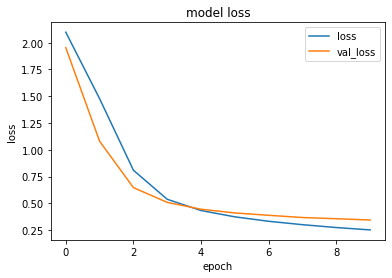

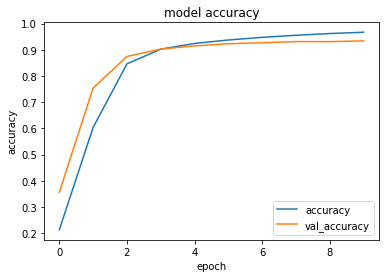

In [28]:
print(history.history.keys())
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'])
plt.show()

accuracy = history.history['accuracy']
val_accuracy= history.history['val_accuracy']
plt.plot(accuracy)
plt.plot(val_accuracy)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()


# **Evaluation**

In [29]:
#accuracy calculation
loss_and_metrics = model.evaluate(padded,train_labels,batch_size=256)
print("The train accuracy is: "+str(loss_and_metrics[1]))
loss_and_metrics = model.evaluate(testing_padded,test_labels,batch_size=256)
print("The test accuracy is: "+str(loss_and_metrics[1]))

386/386 [==============================] - 9s 23ms/step - loss: 0.2366 - accuracy: 0.9724
The train accuracy is: 0.9724036455154419
309/309 [==============================] - 7s 23ms/step - loss: 0.3501 - accuracy: 0.9318
The test accuracy is: 0.931841254234314


In [30]:
predictions = model.predict(testing_padded)

In [31]:
predictions = np.argmax(predictions, axis=-1) 

In [32]:
test_labels=np.argmax(test_labels, axis=-1)

In [33]:
precision, recall, fscore, _ = precision_recall_fscore_support(test_labels,predictions, average='weighted')
print("Precision :"+str(precision))
print("Recall :"+str(recall))
print("fscore :"+str(fscore))

Precision :0.9320740835833812
Recall :0.9318412376363175
fscore :0.931882978117266


# **Confusion Matrix & Classification Report**

,precision,recall,f1-score,support
economy,89.24,92.48,90.83,11583.000000
sports,98.82,97.94,98.38,12692.000000
international,94.23,93.89,94.06,12251.000000
state,89.28,89.45,89.37,12146.000000
technology,90.79,88.05,89.40,7948.000000
entertainment,94.85,95.53,95.19,12194.000000
education,94.12,92.84,93.48,10046.000000
accuracy,93.18,93.18,93.18,0.931841
macro avg,93.05,92.88,92.96,78860.000000
weighted avg,93.21,93.18,93.19,78860.000000


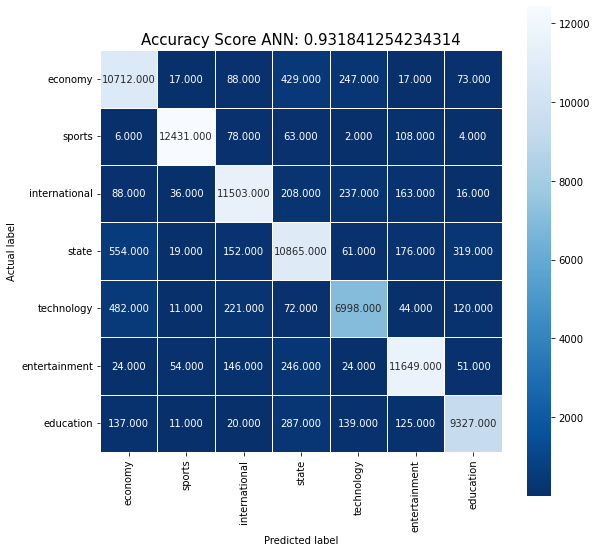

In [34]:
#['economy' 'sports' 'international' 'state' 'technology' 'entertainment' 'education']

cm = metrics.confusion_matrix(test_labels,predictions)
# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,index = ['economy' ,'sports' ,'international', 'state','technology', 'entertainment', 'education'], 
                     columns = ['economy' ,'sports' ,'international', 'state','technology', 'entertainment', 'education'])

plt.figure(figsize=(9,9))
sns.heatmap(cm_df, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score ANN: {0}'.format(loss_and_metrics[1])
plt.title(all_sample_title, size = 15);

report = pd.DataFrame(classification_report(y_true = test_labels, y_pred = predictions, output_dict=True)).transpose()
report = report.rename(index={'0': 'economy','1':'sports','2':'international','3':'state','4':'technology','5':'entertainment','6':'education'})
report[['precision','recall','f1-score']]=report[['precision','recall','f1-score']].apply(lambda x: round(x*100,2))
display(report)